# check 
### the accuracy of the Inverse Laplace transform performed in AstroGK manual Eq. 6.125-126 by comparing with solution from Bromwich integral

In [2]:
import numpy as np
from scipy.special import i0e
import scipy.optimize
from gk_solver.util import real_imag, list2complex, zp
import matplotlib.pyplot as plt
%matplotlib inline

## Term $A$ and $B$ as defined in AstroGK manual

### Eq. 6.115, 6.116

In [3]:
def B(ti_te, mi_me, kperp_rhoi):
    """
    Calculate
    B = sum_s [ (Ti/Ts) ( 1 - Gamma_0(alpha_s)) ]
    """
    alpha_i = kperp_rhoi**2 / 2
    alpha_e = alpha_i / ti_te / mi_me
    return 1 - i0e(alpha_i) - ti_te * (1 - i0e(alpha_e))

In [4]:
def A(ti_te, mi_me, bi, kperp_rhoi, w_bar):
    """
    Calculate
    A  = sum_s [ (Ti/Ts) (1 + Gamma_0s xi_s Z_s) ]
    """
    alpha_i = kperp_rhoi**2 / 2
    alpha_e = alpha_i / ti_te / mi_me
    xi_i = w_bar / np.sqrt(bi)
    xi_e = w_bar * np.sqrt(ti_te / mi_me / bi)
    Z_i = zp(xi_i)
    Z_e = zp(xi_e)
    Gamma_0i = i0e(alpha_i)
    Gamma_0e = i0e(alpha_e)
    return 1 + Gamma_0i * xi_i * Z_i + ti_te * (1 + Gamma_0e * xi_e * Z_e)

In [5]:
def dispersion(ti_te, mi_me, bi, kperp_rhoi, w_bar):
    """
    normalized dispersion relation:
    D(w_bar) = w_bar^2 - alpha_i * A / (A-B) / B
    
    D(w_bar) = 0 yields eigen frequencies
    """
    alpha_i = kperp_rhoi**2 / 2
    a = A(ti_te, mi_me, bi, kperp_rhoi, w_bar)
    b = B(ti_te, mi_me, kperp_rhoi)
    return w_bar**2 - alpha_i * a / (a - b) / b

## fix dimensionless parameters 
$T_i/T_e, k_\perp \rho_i, \omega_0, \beta_i, A_{\parallel 0}$

In [52]:
ti_te = 0.01
kperp_rhoi = 0.4
wbar_0 = 2.7
bi = 0.01
Apar0 = 1
mi_me = 1836

## solve for two Alfven roots $\bar{\omega}_1$ and $\bar{\omega}_2 = \bar{\omega}_1^*$

In [53]:
f = lambda w_bar: real_imag(dispersion(ti_te, mi_me, bi, kperp_rhoi, list2complex(w_bar)))

In [54]:
guess_1 = 1
res = scipy.optimize.fsolve(f, real_imag(guess_1))
wbar_1 = list2complex(res)
print(wbar_1)

(3.05925684009-0.171670515058j)


#### Below we compare to Eq. D21 in Howes (2006) to verify that Alfven the solution is correct

In [55]:
    alpha_i = kperp_rhoi**2 / 2
    alpha_e = alpha_i / ti_te / mi_me
    Gamma_0i = i0e(alpha_i)
    Gamma_0e = i0e(alpha_e)
    
    wbar = np.real(wbar_1)
    gamma = - alpha_i / 2 / (ti_te * Gamma_0e)**2 * np.sqrt(np.pi/bi)
    gamma *= (Gamma_0i * np.exp(-wbar**2/bi) + ti_te**1.5/np.sqrt(mi_me) * Gamma_0e)
    print(gamma)

-0.166183873895


In [56]:
guess_2 = -1
res = scipy.optimize.fsolve(f, real_imag(guess_2))
wbar_2 = list2complex(res)
print(wbar_2)

(-3.05925684009-0.171670515058j)


## Construct solution $A_{\parallel \mathbf{k}}(t)$

In [57]:
def Q2bar(ti_te, mi_me, bi, kperp_rhoi, w_bar):
    """
    Normalized Q^2:
    Q2bar = Q^2/(-kpar^2 va^2) = alpha_i A / (A-B)/B
    """
    alpha_i = kperp_rhoi**2 / 2
    a = A(ti_te, mi_me, bi, kperp_rhoi, w_bar)
    b = B(ti_te, mi_me, kperp_rhoi)
    return alpha_i * a / (a-b) / b

$$
G =  \frac{\alpha_i}{\sqrt{\beta_i} (A-B)^2} \sum_s \left(\frac{T_i}{T_s}\right)^{3/2} \sqrt{\frac{m_s}{m_i}} \Gamma_{0s} \left[(1-2\xi_s^2)Z_s - 2 \xi_s\right]
$$

In [58]:
def G(ti_te, mi_me, bi, kperp_rhoi, w_bar):
    """
    Normalized dQ2/dp
    G = (dQ2/dp) / (-i k_par v_ts)
    """
    alpha_i = kperp_rhoi**2 / 2
    a = A(ti_te, mi_me, bi, kperp_rhoi, w_bar)
    b = B(ti_te, mi_me, kperp_rhoi)
    alpha_e = alpha_i / ti_te / mi_me
    xi_i = w_bar / np.sqrt(bi)
    xi_e = w_bar * np.sqrt(ti_te / mi_me / bi)
    Z_i = zp(xi_i)
    Z_e = zp(xi_e)
    Gamma_0i = i0e(alpha_i)
    Gamma_0e = i0e(alpha_e)
    
    term1 = Gamma_0i * ((1 - 2*xi_i**2) * Z_i - 2 * xi_i)
    term2 = ti_te**1.5 / np.sqrt(mi_me) * Gamma_0e * \
            ((1 - 2*xi_e**2) * Z_e - 2 * xi_e)
    return alpha_i / np.sqrt(bi) / (a-b)**2 * (term1 + term2)
    

In [59]:
G(ti_te, mi_me, bi, kperp_rhoi, wbar_2)

(-0.31182371071889603+0.33498609974596411j)

In [60]:
-wbar_1 - wbar_2

(3.1974423109204508e-14+0.34334103011544748j)

In [61]:
 Q2bar(ti_te, mi_me, bi, kperp_rhoi, wbar_1)

(9.3295816479158002-1.0503683948484046j)

$$
A_{\parallel \mathbf{k}}(t) = Res(\overline{\omega}_0) + Res(\overline{\omega}_1) + Res(\overline{\omega}_2)
$$

In [62]:
def Apark(apark0, tbar):
    """
    
    """
    q2bar_w0 =  Q2bar(ti_te, mi_me, bi, kperp_rhoi, wbar_0)
    res_w0 = q2bar_w0 * np.exp(-1j * wbar_0 * tbar) / \
        (wbar_0**2 - q2bar_w0)
    G_w1 = G(ti_te, mi_me, bi, kperp_rhoi, wbar_1)
    G_w2 = G(ti_te, mi_me, bi, kperp_rhoi, wbar_2)
    res_w1 = wbar_1**2 * np.exp(-1j * wbar_1 * tbar) / \
        (G_w1 + 2 * wbar_1) / (wbar_1 - wbar_0)
    res_w2 = wbar_2**2 * np.exp(-1j * wbar_2 * tbar) / \
        (G_w2 + 2 * wbar_2) / (wbar_2 - wbar_0)
    return apark0 * (res_w0 + res_w1 + res_w2)


def Apark_approx(apark0, tbar):
    """
    
    """
    q2bar_w0 =  Q2bar(ti_te, mi_me, bi, kperp_rhoi, wbar_0)
    res_w0 = q2bar_w0 * np.exp(-1j * wbar_0 * tbar) / \
        (wbar_0**2 - q2bar_w0)
    G_w1 = G(ti_te, mi_me, bi, kperp_rhoi, wbar_1)
    G_w2 = G(ti_te, mi_me, bi, kperp_rhoi, wbar_2)
    res_w1 = wbar_1**2 * np.exp(-1j * wbar_1 * tbar) / \
        (wbar_1-wbar_2) / (wbar_1 - wbar_0)
    res_w2 = wbar_2**2 * np.exp(-1j * wbar_2 * tbar) / \
        (wbar_2 - wbar_1) / (wbar_2 - wbar_0)
    return apark0 * (res_w0 + res_w1 + res_w2)

In [63]:
t_arr = np.linspace(0, 50, 500)

In [64]:
apar_arr = np.array([np.abs(Apark(Apar0, tbar)) for tbar in t_arr])
apar_approx_arr = np.array([np.abs(Apark_approx(Apar0, tbar)) for tbar in t_arr])

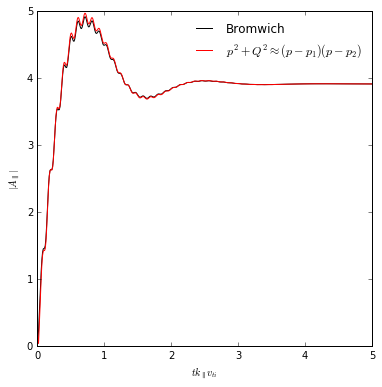

In [65]:
fig = plt.figure(figsize=[6,6])
plt.plot(t_arr * np.sqrt(bi), apar_arr, 'k', label='Bromwich')
plt.plot(t_arr * np.sqrt(bi), apar_approx_arr, 'r', label = r'$p^2+Q^2 \approx (p-p_1)(p-p_2)$')
plt.ylabel(r'$|A_\parallel|$')
plt.xlabel(r'$tk_\parallel v_{ti}$')
plt.legend(loc='best', frameon=False)
plt.show()

In [19]:
# fig.savefig('bromwich_vs_approx.eps')

### compare with AstroGK simulation

In [20]:
data_dir = '/Volumes/yuguang_sd/data/agk/lin_response/lin_alf_1'
filename = data_dir + '/lin_alf_1.apar'

dtype = {'names': ('f1', 't', 'f2', 'apar2', 'f3', 'f4', 'h1', 'h2'),
         'formats': ('S2', 'f4', 'S10', 'f4', 'S10', 'S10', 'f4', 'f4')}
data = np.loadtxt(filename, dtype = dtype)

apar2 = np.array([elem[3] for elem in data])
apar = np.sqrt(apar2)
t = np.array([elem[1] for elem in data])

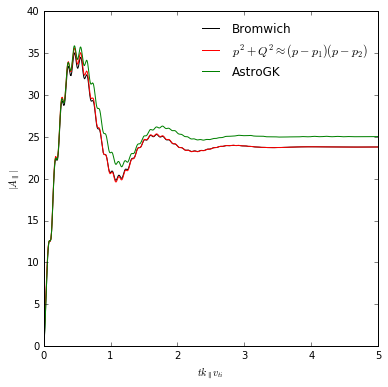

In [21]:
fig2 = plt.figure(figsize=[6,6])
plt.plot(t_arr * np.sqrt(bi), apar_arr, 'k', label='Bromwich')
plt.plot(t_arr * np.sqrt(bi), apar_approx_arr, 'r', label = r'$p^2+Q^2 \approx (p-p_1)(p-p_2)$')
plt.plot(t, apar * np.sqrt(8), 'g', markersize=1, label='AstroGK')
plt.ylabel(r'$|A_\parallel|$')
plt.xlabel(r'$tk_\parallel v_{ti}$')
plt.legend(loc='best', frameon=False)
plt.xlim([0, 5])
plt.show()

In [22]:
# fig2.savefig('bromwich_vs_agk.eps')